<a href="https://colab.research.google.com/github/cjqian/flappy/blob/master/card_game/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The card game

Let's wager on a card game. In front of you is a shuffled deck of 52 cards face-down. Half are red, half are black. Once you saw "halt", I'll flip over the next card and end the game. If the final card is red, you win \$1. Otherwise, you lose \$1. Let's play!

In [14]:
import numpy as np
import pandas as pd
import random

# Set up the game/environment.

In [118]:
# The actions are to stop or to continue.
ACTION_GO = 0
ACTION_STOP = 1

# The observation is the entire history of the game thus far. [RED, BLACK...]
CARD_RED = 0
CARD_BLACK = 1

DECK_SIZE = 52

class Environment():
  def __init__(self):
    self._dealt_cards = []
    
    # Same number of red and black cards.
    red_cards = [CARD_RED] * int(DECK_SIZE / 2)
    black_cards = [CARD_BLACK] * int(DECK_SIZE / 2)
    self._deck = red_cards + black_cards
    random.shuffle(self._deck)

  def step(self, action):
    """Returns reward, state, and whether the game is done."""
    done = False
    if len(self._deck) == 1 or action == ACTION_STOP:
      done = True
      
    card = self._deck.pop()
    self._dealt_cards.append(card)

    reward = 0

  # The rewards are $1 if we win, -$1 if we lost,
  # or $0 if the game has not ended.
    if done:
      reward = 1 if card == CARD_RED else -1
    return (self._dealt_cards, reward, done)

# Approach 0: Random Baseline

Progress: 0.2 (0.0022)
Progress: 0.4 (0.0022)
Progress: 0.6 (0.0022)
Progress: 0.8 (0.0022)
Progress: 1.0 (0.0022)
Score over time: 0.0044


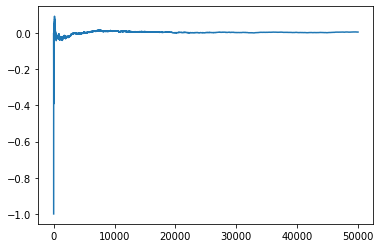

In [124]:
RANDOM_REWARDS = []

for episode in range(1, total_episodes+ 1):
    if (episode % 10000) == 0:
        print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                         round(sum(rewards) / len(rewards), 4)))
    # Reset the environment
    env = Environment()
    state, reward, done = env.step(ACTION_GO)
    state_h = get_hash_key(state)
    step = 0
    total_rewards = 0
    
    while not done:
        action = random.randint(0, 1)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done = env.step(action)
        new_state_h = get_hash_key(new_state)

        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
    # Reduce epsilon (because we need less and less exploration)
    RANDOM_REWARDS.append(total_rewards)
    
print ("Score over time: " +  str(sum(rewards)/total_episodes))

# Plot learning.
pd.Series(RANDOM_REWARDS).expanding().mean().plot()

# Approach 1: Q Learning

In [133]:
# Initialize hyperparameters.

total_episodes = 100000       # Total episodes
learning_rate = 0.7          # Learning rate
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

In [ ]:
%%time

def get_hash_key(state):
  return ''.join([str(x) for x in state])

# List of rewards
rewards = []
q_map  = {}

# 2 For life or until learning is stopped
for episode in range(1, total_episodes+ 1):
    if (episode % 10000) == 0:
        print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                         round(sum(rewards) / len(rewards), 4)))
    # Reset the environment
    env = Environment()
    state, reward, done = env.step(ACTION_GO)
    state_h = get_hash_key(state)
    step = 0
    total_rewards = 0
    
    while not done:
        exp_tradeoff = random.uniform(0, 1)
        explore = exp_tradeoff <= epsilon

        if state_h not in q_map:
          q_map[state_h] = [0.0, 0.0]

        if explore:
          # Choose a random action.
          action = random.randint(0, 1)
        else:
          action = np.argmax(q_map[state_h])

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done = env.step(action)
        new_state_h = get_hash_key(new_state)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        if new_state_h not in q_map:
          q_map[new_state_h] = [0.0, 0.0]

        q_map[state_h][action] = q_map[state_h][action] + learning_rate * (
            reward + gamma * np.max(q_map[new_state_h]) - q_map[state_h][action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    
print ("Score over time: " +  str(sum(rewards)/total_episodes))

# Plot learning.
Q_LEARNING_REWARDS = rewards
pd.Series(Q_LEARNING_REWARDS).expanding().mean().plot()

Progress: 0.1 (0.0031)
Progress: 0.2 (0.0017)
Progress: 0.3 (0.003)
Progress: 0.4 (-0.0003)
Progress: 0.5 (-0.0029)
Progress: 0.6 (-0.0034)
Progress: 0.7 (-0.0032)


# Test it out!

Hypothesis: q-learning isn't great for this; there is too large of a state space.

In [117]:
N_TRIALS = 100
trial_rewards = []

for episode in range(N_TRIALS):
    env = Environment()
    state, _, done = env.step(ACTION_GO)

    while (not done):
        state_h = get_hash_key(state)
        # Take the action (index) that have the maximum expected future reward given that state
        if state_h in q_map: 
          action = np.argmax(q_map[state_h])
        else:
          action = ACTION_GO 

        new_state, reward, done = env.step(action)
        
        if done:
            # We print the number of step it took.
    #        print("\tEpisode {}: {}".format(episode, reward))
            trial_rewards.append(reward)
            break

        state = new_state

print("Payoff: {}".format(sum(trial_rewards)))

KeyboardInterrupt: ignored